In [97]:
import numpy as np 
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import pandas as pd
from scipy import stats
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, RandomFlip, RandomRotation, BatchNormalization, SpatialDropout2D
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import RobustScaler
from tensorflow.keras.metrics import BinaryCrossentropy as metricBinaryCrossentropy
from tensorflow.keras.losses import SparseCategoricalCrossentropy, BinaryCrossentropy
from tensorflow import cast, expand_dims, float32
from tensorflow.image import resize_with_crop_or_pad
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score

In [98]:
# df = pd.read_pickle("blind_cameras_dataset\\drdf_arrays.pkl")
# df2arr = df.pixels.to_numpy()
# arr3d = np.stack(df2arr)
# data = arr3d.reshape(df2arr.shape[0],32*32)

In [99]:
data_path = './blind_cameras_dataset'
#neutrino-01 path: '/storage/gpfs_data/neutrino/SAND-LAr/SAND-LAr-OPTICALSIM-PROD/GRAIN/blindcam/data'

# Load Data 
with open(data_path+'/simulation_0.npy', 'rb') as a:    #'+str(sim_num)+'
    data_in_0 = np.load(a)  
with open(data_path+'/simulation_1.npy', 'rb') as b:    #'+str(sim_num)+'
    data_in_1 = np.load(b)
with open(data_path+'/simulation_25.npy', 'rb') as c:    #'+str(sim_num)+'
    data_in_2 = np.load(c)
    
# Load MC Truth
with open(data_path+'/inner_ph_0.npy', 'rb') as e:      #'+str(sim_num)+'
    inner_ph_in_0 = np.load(e)
with open(data_path+'/inner_ph_1.npy', 'rb') as f:      #'+str(sim_num)+'
    inner_ph_in_1 = np.load(f)
with open(data_path+'/inner_ph_25.npy', 'rb') as g:      #'+str(sim_num)+'
    inner_ph_in_2 = np.load(g)

# inner_ph_in = np.stack(inner_ph_in_1, inner_ph_in_25)
# data_in = np.stack(data_in_1, data_in_25)
# data_in = data_in_25
# inner_ph_in = inner_ph_in_25

###### fixed parameters ###########
n_cam_0 = 54
side_length_0 = 31
n_cam_1 = 58
side_length_1 = 32
n_cam_2 = 58
side_length_2 = 32

In [100]:
print(data_in_0.shape)
print(data_in_1.shape)
print(data_in_2.shape)

(51894000,)
(59392000,)
(3385344,)


In [101]:
data_in_0.reshape(31, 31,-1).T.T.shape

(31, 31, 54000)

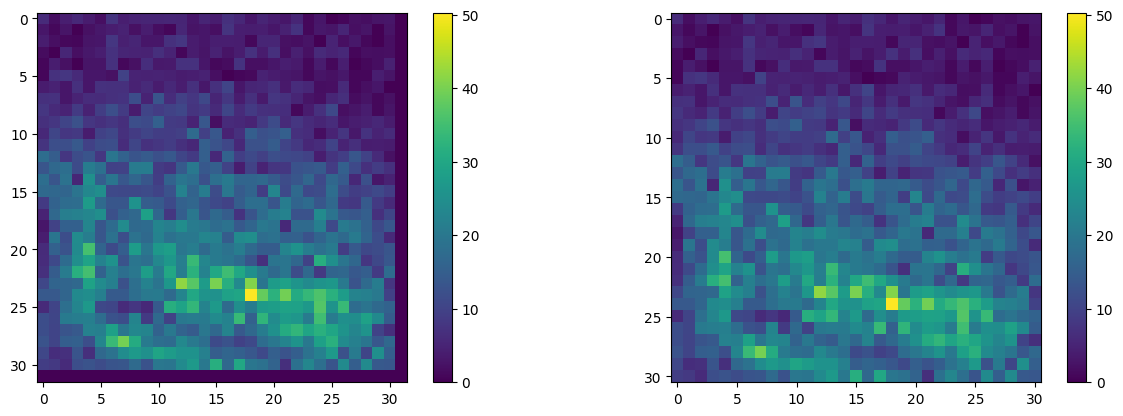

In [111]:
new_data_0 = np.array(resize_with_crop_or_pad(data_in_0.reshape(-1, 31, 31).T, 32, 32)).T

new_data_0.reshape(-1,1)

fig, ax = plt.subplots(1,2)
matrix0 = ax[0].imshow(new_data_0.reshape(-1, 32, 32)[351])
#matrix0 = ax[0].imshow(data_in_1[(10,5)].reshape(side_length_1, side_length_1))
fig.colorbar(matrix0)
             
matrix1 = ax[1].imshow(data_in_0.reshape(-1,31, 31)[351]) 
#matrix0 = ax[0].imshow(data_in_1[(10,5)].reshape(side_length_1, side_length_1))
fig.colorbar(matrix1)

fig.set_figwidth(15)

In [103]:
print('data:',new_data_0.reshape(-1, n_cam_0, side_length_1**2).shape)
print('mc:',inner_ph_in_0.reshape(n_cam_0, -1).shape)
print('-------------')
print('data:',data_in_1.reshape(-1, n_cam_1, side_length_1**2).shape)
print('mc:',inner_ph_in_1.reshape(n_cam_1, -1).shape)
print('-------------')
print('data:',data_in_2.reshape(-1, n_cam_2, side_length_2**2).shape)
print('mc:',inner_ph_in_2.reshape(n_cam_2, -1).shape)

data: (1000, 54, 1024)
mc: (54, 1000)
-------------
data: (1000, 58, 1024)
mc: (58, 1000)
-------------
data: (57, 58, 1024)
mc: (58, 10000)


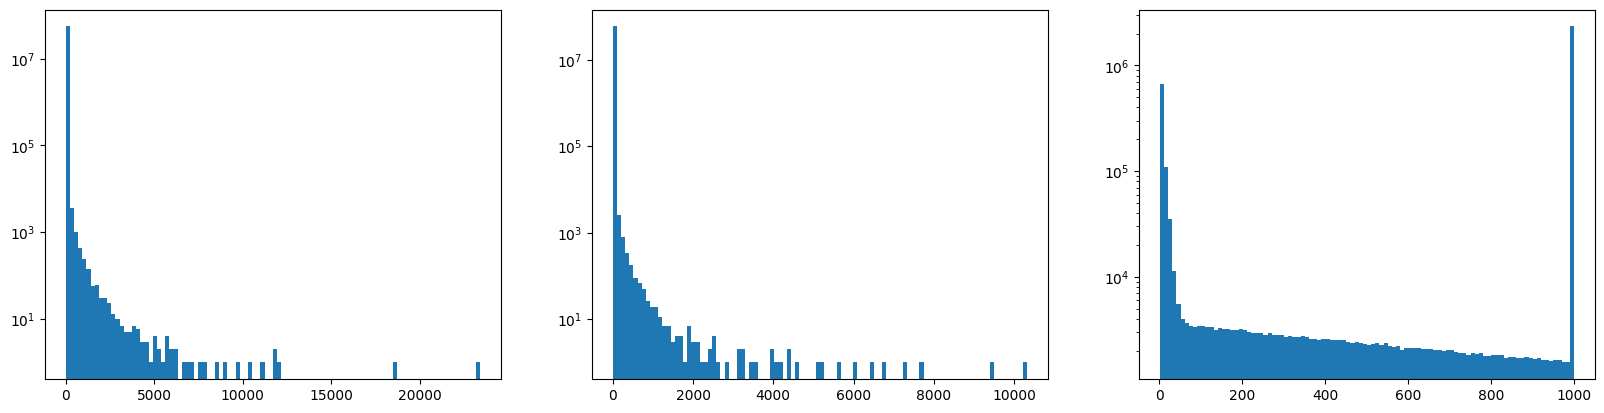

In [104]:
fig, ax = plt.subplots(1,3)

ax[0].hist(new_data_0.reshape(-1,1),100)   #[data_in_0<1001]
ax[1].hist(data_in_1.reshape(-1,1),100)
ax[2].hist(data_in_2.reshape(-1,1),100)
ax[0].set_yscale('log')
ax[1].set_yscale('log')
ax[2].set_yscale('log')

fig.set_figwidth(20)

data_in_0  = data_in_0.reshape(-1, n_cam_0, side_length_0**2)
inner_ph_in_0 = inner_ph_in_0.reshape(n_cam_0, -1)

data_in_1 = data_in_1.reshape(-1, n_cam_1, side_length_1**2)
inner_ph_in_1 = inner_ph_in_1.reshape(n_cam_1, -1)

data_in_2 = data_in_2.reshape(-1, n_cam_2, side_length_2**2)
inner_ph_in_2 = inner_ph_in_2.reshape(n_cam_2, -1)

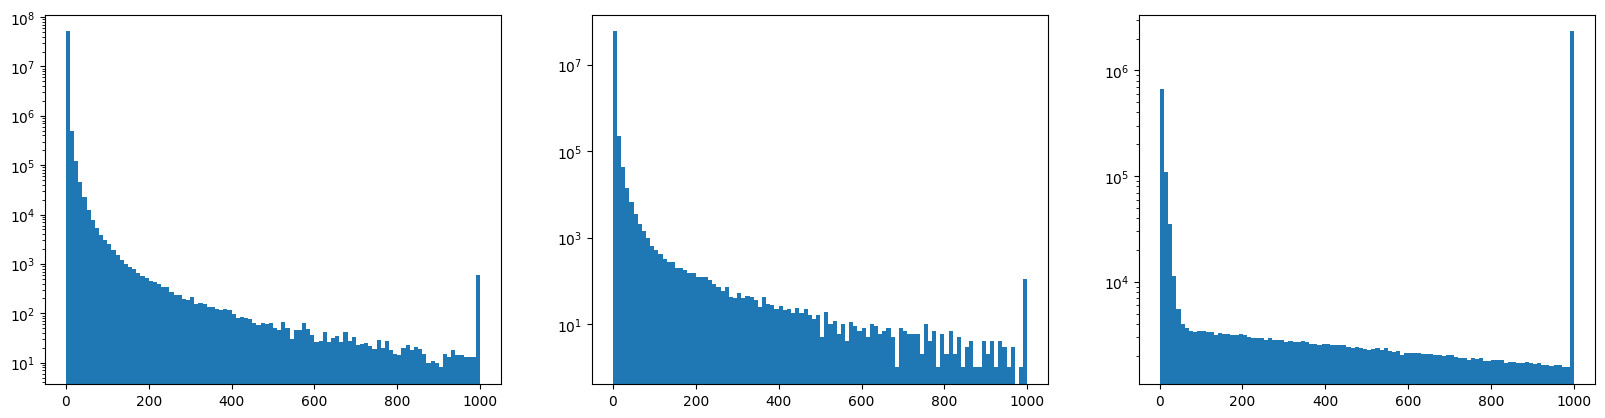

In [105]:
fig, ax = plt.subplots(1,3)

data_in_00 = data_in_0
data_in_00[data_in_00 > 1000] = 1000

data_in_11 = data_in_1
data_in_11[data_in_11 > 1000] = 1000

ax[0].hist(data_in_00.reshape(-1,1),100)   #[data_in_0<1001]
ax[1].hist(data_in_11.reshape(-1,1),100)
ax[2].hist(data_in_2.reshape(-1,1),100)
ax[0].set_yscale('log')
ax[1].set_yscale('log')
ax[2].set_yscale('log')

fig.set_figwidth(20)

data_in_00  = data_in_00.reshape(-1, n_cam_0, side_length_0**2)
inner_ph_in_0 = inner_ph_in_0.reshape(n_cam_0, -1)

data_in_11 = data_in_11.reshape(-1, n_cam_1, side_length_1**2)
inner_ph_in_1 = inner_ph_in_1.reshape(n_cam_1, -1)

data_in_2 = data_in_2.reshape(-1, n_cam_2, side_length_2**2)
inner_ph_in_2 = inner_ph_in_2.reshape(n_cam_2, -1)

(594,) (594,)
(108,) (108,)
(2331191,) (2331191,)


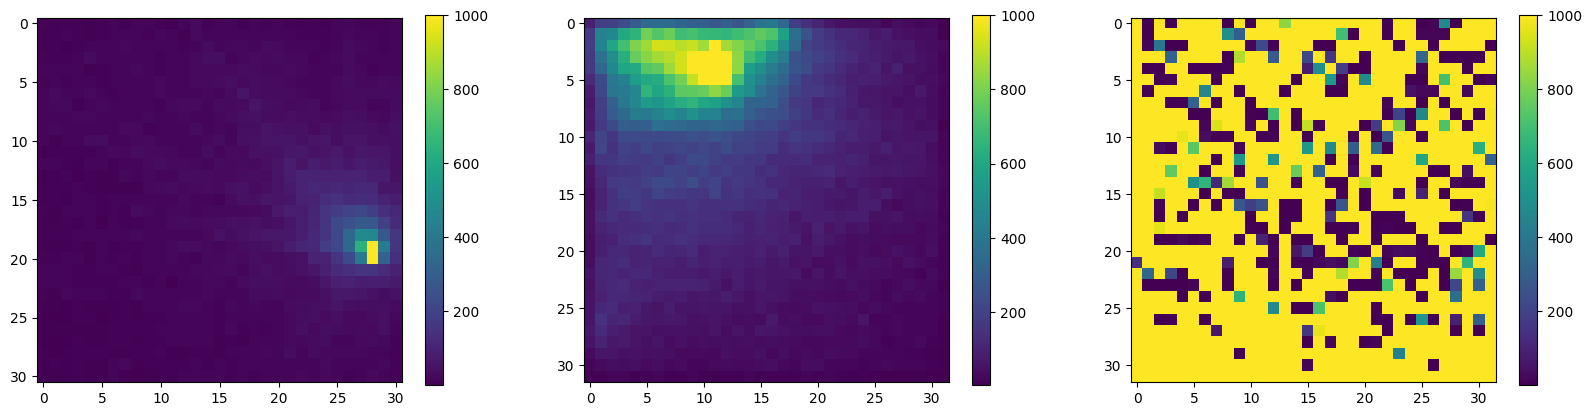

In [106]:
evn = 20
cam = 20
evn0 = (np.where(data_in_00 == np.max(data_in_00))[0])
cam0 = (np.where(data_in_00 == np.max(data_in_00))[1])
evn1 = (np.where(data_in_1 == np.max(data_in_1))[0])
cam1 = (np.where(data_in_1 == np.max(data_in_1))[1])
evn2 = (np.where(data_in_2 == np.max(data_in_2))[0])
cam2 = (np.where(data_in_2 == np.max(data_in_2))[1])
print(evn0.shape, cam0.shape)
print(evn1.shape, cam1.shape)
print(evn2.shape, cam2.shape)

fig, ax = plt.subplots(1,3)
matrix0 = ax[0].imshow(data_in_00[(evn0[evn],cam0[cam])].reshape(side_length_0, side_length_0))
#matrix0 = ax[0].imshow(data_in_1[(10,5)].reshape(side_length_1, side_length_1))
fig.colorbar(matrix0)
             
matrix1 = ax[1].imshow(data_in_1[(evn1[evn],cam1[cam])].reshape(side_length_1, side_length_1))
#matrix0 = ax[0].imshow(data_in_1[(10,5)].reshape(side_length_1, side_length_1))
fig.colorbar(matrix1)

matrix2 = ax[2].imshow(data_in_2[(evn2[evn],cam2[cam])].reshape(side_length_2, side_length_2))
#matrix1 = ax[1].imshow(data_in_2[(10,5)].reshape(side_length_2, side_length_2))
fig.colorbar(matrix2)

fig.set_figwidth(20)

In [107]:
np.max(data_in_00)

1000.0

In [108]:
plt.hist(data.reshape(-1,1),100)
plt.yscale('log')

NameError: name 'data' is not defined

In [ ]:
data_num = 21449

fig = plt.figure()
ax = plt.axes(projection='3d')

a = np.arange(32)
x,y = np.meshgrid(a,a)
z = arr3d[data_num]

ls = LightSource(270, 45)
# To use a custom hillshading mode, override the built-in shading and pass
# in the rgb colors of the shaded surface calculated from "shade".
rgb = ls.shade(z, cmap=cm.gist_earth, vert_exag=0.1, blend_mode='soft')

ax.plot_surface(x,y,z,facecolors=rgb) #cmap='viridis'
ax.set_xlabel('x')
ax.set_ylabel('y')

fig.set_figheight(10)

print('mean threshold :',skimage.filters.threshold_mean(z))
print('maximum :', np.max(z))
print('ratio max/mean :', np.max(z)/skimage.filters.threshold_mean(z))

In [ ]:
data_num = 42015#31#8576#39051#42015

def filt_func(r, c, sigma=0.01):
    return np.exp(-(r**2 + c**2)/(2 * sigma**2))


forw = skimage.filters.filter_forward(arr3d[data_num], filt_func)
med = skimage.filters.median(arr3d[data_num])
gauss = skimage.filters.gaussian(arr3d[data_num]) #sigma? mode?
hess = skimage.filters.hessian(arr3d[data_num]) #sigmas? scale_range?
frangi = skimage.filters.frangi(arr3d[data_num])
sato = skimage.filters.sato(arr3d[data_num])
mei = skimage.filters.meijering(arr3d[data_num])

thr_iso = skimage.filters.threshold_isodata(image=arr3d[data_num], nbins=32*32)
thr_loc = skimage.filters.threshold_local(arr3d[data_num]) #method='gaussian'
thr_mean = skimage.filters.threshold_mean(arr3d[data_num])
thr_min = skimage.filters.threshold_minimum(image=arr3d[data_num], nbins=32*32)

print('iso thr :',thr_iso)
print('mean thr :',thr_mean)
print('min thr :', thr_min)

fig, ax = plt.subplots(3,2)
cam0 = ax[0,0].pcolormesh(arr3d[data_num])
plt.colorbar(cam0)
ax[0,0].set_title('original')

cam1 = ax[0,1].pcolormesh(forw)#(arr3d[data_num]>thr_iso)
plt.colorbar(cam1)
ax[0,1].set_title('forw filter')

cam2 = ax[1,0].pcolormesh(hess)#(arr3d[data_num]>thr_mean)
plt.colorbar(cam2)
ax[1,0].set_title('hess filter')

cam3 = ax[1,1].pcolormesh(hess*arr3d[data_num])#(arr3d[data_num]>thr_min)
plt.colorbar(cam3)
ax[1,1].set_title('hess*data filter')

cam2 = ax[2,0].pcolormesh(gauss)#(arr3d[data_num]>thr_mean)
plt.colorbar(cam2)
ax[2,0].set_title('gauss filter')

cam2 = ax[2,1].pcolormesh(thr_loc)#(arr3d[data_num]>thr_mean)
plt.colorbar(cam2)
ax[2,1].set_title('thr loc filter')

fig.set_figwidth(15)
fig.set_figheight(16)

In [ ]:
data_num = 42015

fig, ax = plt.subplots(1,2)
cam0 = ax[0].pcolormesh(arr3d[data_num])
plt.colorbar(cam0)
ax[0].set_title('non scaled')

cam = ax[1].pcolormesh(scaled2.reshape(-1,32,32)[data_num])
plt.colorbar(cam)
ax[1].set_title('scaled')

fig.set_figwidth(15)